In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os
import dash
from dash import html, dcc, Output, Input, Dash
import plotly.graph_objects as go
from matplotlib.patches import Rectangle, Circle
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib

In [2]:
def open_json(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        return data

def sanity_check(data, file):
    required_keys = {
        'id_app',
        'link',
        'description',
        'name',
        'installation_count',
        #'services_name',
        'trigger',
        'action',
        'permissions_trigger',
        'permissions_action',
        'node_color',
        'trigger',
        'action'
    }

    invalid_keys = [k for k in required_keys if not data.get(k)]
    if invalid_keys:
        print(f"Empty or None values in file {file}: {invalid_keys}")

############################# DATA EXTRACTION
def extract_fine_grained(data):
    fine_grained_triggers = data['data']['applet']['trigger']['ingredients']
    fine_grained_trigger_endpoints = {}
    for fine_grained_trigger in fine_grained_triggers:
        name = fine_grained_trigger['slug'].lower()
        if name not in fine_grained_trigger_endpoints:
            fine_grained_trigger_endpoints[name] = []
        fine_grained_trigger_endpoints[name].append(fine_grained_trigger['normalized_name'].lower())
    fine_grained_action_endpoints = {}
    #fine_grained_actions = data['appletDetails']['normalized_applet']['stored_fields']
    fine_grained_actions = data['data']['applet']['actions'][0]['action_fields']
    for fine_grained_action in fine_grained_actions:
        name = fine_grained_action['normalized_module_name']
        if name not in fine_grained_action_endpoints:
            fine_grained_action_endpoints[name] = []
        endpoint = data['data']['applet']['trigger']['full_normalized_module_name'].lower() 
        fine_grained_action_endpoints[name].append(endpoint)
    return fine_grained_trigger_endpoints, fine_grained_action_endpoints    

def extract_features(json):
    id_app = json['data']['applet']['id']
    link = 'https://ifttt.com/applets/'+json['data']['applet']['friendly_id']
    description = json['data']['applet']['description']
    name = json['data']['applet']['name']
    installation_count = json['data']['applet']['installs_count']
    #services_name = [json['data']['applet']['channels'][0]['name'], json['data']['applet']['channels'][1]['name']]
    trigger = json['data']['applet']['channels'][0]['name']
    try:
        action = json['data']['applet']['channels'][1]['name']
    except:
        action = json['data']['applet']['channels'][0]['name']
    permissions_trigger = "/triggers/"+json['data']['applet']['trigger']['full_normalized_module_name'].lower()
    permissions_action = "/actions/"+json['data']['applet']['actions'][0]['full_normalized_module_name'].lower()
    node_color = '#'+json['data']['applet']['channels'][0]['brand_color']
    fine_grained_trigger = extract_fine_grained(json)[0]
    fine_grained_action = extract_fine_grained(json)[1]
    return {
        'id_app': id_app,
        'link': link,
        'description': description,
        'name': name,
        'installation_count': installation_count,
        #'services_name': services_name,
        'trigger': trigger,
        'action': action,
        'permissions_trigger': permissions_trigger,
        'permissions_action': permissions_action,
        'node_color': node_color,
        'fine_grained_trigger': fine_grained_trigger,
        'fine_grained_action': fine_grained_action
    }

def get_data_category(app_categories, node_permission):
    data_category = 'unknown'
    service = node_permission[node_permission.find('/', node_permission.find('/')+1):node_permission.find('.', node_permission.find('/', node_permission.find('/')+1))].replace('/', '').lower()
    for c, s in app_categories.items():
        s = [item.replace('_', '') for item in s]
        if service in s:
            data_category = c
    return data_category

def get_privacy_policy(service):
    if " " in service:
        service = service.split(" ")[0]
    file_path = f'./data/privacy_policy/{service}.txt'
    
    if not os.path.exists(file_path):
        return html.P("Privacy policy not available.")

    with open(file_path, 'r') as f:
        text = f.read()

    lines = text.splitlines()
    bullet_lines = []
    paragraph_lines = []

    for line in lines:
        stripped = line.strip()
        if stripped.startswith(("•", "*", "-")):
            bullet_lines.append(stripped.lstrip("•*- ").strip())
        elif stripped:
            paragraph_lines.append(stripped)

    elements = []

    if paragraph_lines:
        for para in paragraph_lines:
            elements.append(html.P(para))

    if bullet_lines:
        elements.append(html.Ul([html.Li(bullet) for bullet in bullet_lines]))

    return html.Div(elements)

############################ GRAPH CREATION
def new_node(G, data, node, app_categories):
    if node in data['trigger']:
        G.add_node(node, 
                   id_app=[data['id_app']], 
                   url=[data['link']],
                   description=[data['description']],
                   installation_count=[str(abs(int(data['installation_count'])))],
                   color=data['node_color'],
                   trigger=[data['trigger']],
                   action=[data['action']],
                   permission =[data['permissions_trigger']],
                   fine_grained_trigger=[data['fine_grained_trigger']],
                   fine_grained_action=[data['fine_grained_action']],
                   data_category=[get_data_category(app_categories, data['permissions_trigger'])])      
    if node in data['action']:
        G.add_node(node, 
                   id_app=[data['id_app']], 
                   url=[data['link']],
                   description=[data['description']],
                   installation_count=[str(abs(int(data['installation_count'])))],
                   color=data['node_color'],
                   trigger=[data['trigger']],
                   action=[data['action']],
                   permission=[data['permissions_action']],
                   fine_grained_trigger=[data['fine_grained_trigger']],
                   fine_grained_action=[data['fine_grained_action']],
                   data_category=[get_data_category(app_categories, data['permissions_action'])])  
    return G

def update_node(G, data, node, app_categories):
    if node in data['trigger']:
        G.nodes[node]['id_app'].append(data['id_app'])
        G.nodes[node]['url'].append(data['link'])
        G.nodes[node]['description'].append(data['description'])
        G.nodes[node]['installation_count'].append(str(abs(int(data['installation_count']))))
        G.nodes[node]['color'] = data['node_color']
        G.nodes[node]['trigger'].append(data['trigger'])
        G.nodes[node]['action'].append(data['action'])
        G.nodes[node]['permission'].append(data['permissions_trigger'])
        G.nodes[node]['fine_grained_trigger'].append(data['fine_grained_trigger'])
        G.nodes[node]['fine_grained_action'].append(data['fine_grained_action'])
        G.nodes[node]['data_category'].append(get_data_category(app_categories, data['permissions_trigger']))
    if node in data['action']:
        G.nodes[node]['id_app'].append(data['id_app'])
        G.nodes[node]['url'].append(data['link'])
        G.nodes[node]['description'].append(data['description'])
        G.nodes[node]['installation_count'].append(str(abs(int(data['installation_count']))))
        G.nodes[node]['color'] = data['node_color']
        G.nodes[node]['trigger'].append(data['trigger'])
        G.nodes[node]['action'].append(data['action'])
        G.nodes[node]['permission'].append(data['permissions_action'])
        G.nodes[node]['fine_grained_trigger'].append(data['fine_grained_trigger'])
        G.nodes[node]['fine_grained_action'].append(data['fine_grained_action'])
        G.nodes[node]['data_category'].append(get_data_category(app_categories, data['permissions_action']))
    return G

def create_graph(app_list, app_categories):
    G = nx.DiGraph()
    for data in app_list:
        for node in [data['trigger'], data['action']]:
            if node not in G.nodes:
                G = new_node(G, data, node, app_categories)
            else:
                G = update_node(G, data, node, app_categories)
        #G.add_edge(data['trigger'], data['action'], label='trigger', id_app=data['id_app'])
        G.add_edge(data['trigger'], data['action'], id_app=data['id_app'])

    return G

############################ EXPORTING GRAPH
def export_graph_to_json(G, pos, filename="figma_data.json"):
    data = {
        "nodes": [],
        "edges": []
    }

    for node, attr in G.nodes(data=True):
        node_data = {
            "id_app": attr.get("id_app", []),
            "service": node,
            "position": {"x": pos[node][0], "y": pos[node][1]},
            "url": attr.get("url", []),
            "description": attr.get("description", []),
            "installation_count": attr.get("installation_count", []),
            "color": attr.get("color", "#000000"),
            "trigger": attr.get("trigger", []),
            "action": attr.get("action", []),
            "permission": attr.get("permission", [])
        }
        data["nodes"].append(node_data)

    for source, target, edge_attr in G.edges(data=True):
        data["edges"].append({
            "source": source,
            "target": target,
            "label": edge_attr.get("label", "")
        })

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def network_metrics(graph: nx.Graph) -> None:

    """
    this function print out some network metrics
    comment and uncomment print line are due to the fact that some of these metrics are strictly related
    to a directional or undirectional network (connections between nodes)
    """    

    #max_de = max(nx.degree_centrality(graph).items(), key=itemgetter(1))
    #max_clo = max(nx.closeness_centrality(graph).items(), key=itemgetter(1))
    #max_bet = max(nx.betweenness_centrality(graph, normalized=True, endpoints=False).items(), key=itemgetter(1))
    #print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
    #print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
    #print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

    information = {}
    information['total_nodes'] = graph.number_of_nodes()
    information['total_edges'] = graph.number_of_edges()
    print('total_nodes', information['total_nodes'])
    print('total_edges', information['total_edges'])
    information['max_in_degree'] = sorted(dict(graph.in_degree()).items(), key=lambda kv: kv[1], reverse=True)[:1]
    information['max_out_degree'] = sorted(dict(graph.out_degree()).items(), key=lambda kv: kv[1], reverse=True)[:1]
    print('max_in_degree', information['max_in_degree'])
    print('max_out_degree', information['max_out_degree'])
    information['max_degree_centrality'] = sorted(dict(nx.degree_centrality(graph).items()), key=lambda kv: kv[1], reverse=True)[:1]
    information['max_closeness_centrality'] = sorted(dict(nx.closeness_centrality(graph).items()), key=lambda kv: kv[1], reverse=True)[:1]
    information['max_betweenness_centrality'] = sorted(dict(nx.betweenness_centrality(graph, normalized=True, endpoints=False).items()), key=lambda kv: kv[1], reverse=True)[:1]
    information['pagerank'] = sorted(dict(nx.pagerank(graph).items()), key=lambda kv: kv[1], reverse=True)[:10]
    return information

def draw_graph(G):
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, k=2, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'label')
    node_colors = [G.nodes[node].get('color', '#8cc251') for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=10,
        arrows=True
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.show()

### INTERFACE
NODE_IMAGE_MAP = {
    "Spotify": "https://cdn-icons-png.flaticon.com/512/174/174872.png",
    "Gmail": "https://cdn-icons-png.flaticon.com/512/281/281769.png",
    "Google Calendar": "https://cdn-icons-png.flaticon.com/512/732/732208.png",
    "YouTube": "https://cdn-icons-png.flaticon.com/512/1384/1384060.png",
    "Google": "https://cdn-icons-png.flaticon.com/128/300/300221.png",
    "Twitter": "https://cdn-icons-png.flaticon.com/128/733/733579.png",
    "Philips Hue": "https://cdn-icons-png.flaticon.com/128/882/882703.png",
    "Facebook": "https://cdn-icons-png.flaticon.com/128/145/145802.png",
    "IFTTT": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Instagram": "https://cdn-icons-png.flaticon.com/128/3955/3955024.png",
    "Android SMS": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "Android Device": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "Android Photos": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "Android Phone Call": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "iOS Contacts": "https://cdn-icons-png.flaticon.com/128/731/731985.png",
    "iOS Photos": "https://cdn-icons-png.flaticon.com/128/731/731985.png",
    "Google Drive": "https://cdn-icons-png.flaticon.com/128/5968/5968523.png",
    "Google Contacts": "https://cdn-icons-png.flaticon.com/128/720/720236.png",
    "Google Sheets": "https://cdn-icons-png.flaticon.com/128/281/281761.png",
    "Weather Underground": "https://cdn-icons-png.flaticon.com/128/1163/1163661.png",
    "RSS Feed": "https://cdn-icons-png.flaticon.com/128/3670/3670120.png",
    "VoIP Calls": "https://cdn-icons-png.flaticon.com/128/1674/1674983.png",
    "Space": "https://cdn-icons-png.flaticon.com/128/1067/1067357.png",
    "Notifications": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Location": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Button widget": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Date & Time": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Email": "https://cdn-icons-png.flaticon.com/128/3178/3178158.png"

}

def create_edges_and_annotations(G, pos):
    edge_trace = []
    annotations = []

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]

        # Line trace for edge
        edge_trace.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=1, color='gray'),
            mode='lines',
            hoverinfo='none'
        ))

        # Arrow shape
        annotations.append(dict(
            ax=x0, ay=y0,
            x=x1, y=y1,
            xref='x', yref='y',
            axref='x', ayref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=1,
            arrowwidth=1.5,
            opacity=0.7
        ))

        # Edge label
        label = G.edges[edge].get('label', '')
        mid_x, mid_y = (x0 + x1) / 2, (y0 + y1) / 2
        annotations.append(dict(
            x=mid_x, y=mid_y,
            text=label,
            showarrow=False,
            font=dict(size=10, color="red"),
            xanchor="center",
            yanchor="bottom"
        ))

    return edge_trace, annotations

def create_node_trace(G, pos):
    node_x, node_y, node_text, node_ids, node_colors = [], [], [], [], []

    for node, attrs in G.nodes(data=True):
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
        node_ids.append(node)
        node_colors.append(attrs.get('color', '#1f77b4'))
        #node_colors.append('#FFFFFF')
    return go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="top center",
        hoverinfo='text', #WHEN YOU GO OVER A NODE, SHOW ALL INFO
        marker=dict(
            size=20,
            color=node_colors,
            line=dict(width=2, color='black')
        ),
        customdata=node_ids
    )

def create_node_images(G, pos, icon_map, size=0.12):
    node_images = []

    for node, (x, y) in pos.items():
        if node in icon_map:
            node_images.append(dict(
                source=icon_map[node],
                xref="x",
                yref="y",
                x=x - size / 5,  # Center horizontally
                y=y,# + size / 2,  # Move up slightly to sit above
                sizex=size,
                sizey=size,
                xanchor="left",
                yanchor="middle",
                layer="above"
            ))
    return node_images

def create_dash_layout(edge_trace, node_trace, annotations, node_images):
    return html.Div([
        html.H2("IFTTT Graph: Trigger → Action", style={"textAlign": "center"}),
        dcc.Graph(
            id='network-graph',
            figure={
                'data': edge_trace + [node_trace],
                'layout': go.Layout(
                    clickmode='event+select',
                    showlegend=False,
                    margin=dict(l=20, r=20, t=20, b=20),
                    hovermode='closest',
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    annotations=annotations,
                    images=node_images  # ← added image layer
                )
            },
            style={"height": "600px"}
        ),
        html.Div(id='node-info', style={"padding": "10px", "fontSize": "16px"}),
    ])

def display_node_info(G, clickData, graph_info):
    if clickData and 'customdata' in clickData['points'][0]:
        node = clickData['points'][0]['customdata']
        data = G.nodes[node]

        id_apps = data.get('id_app', [])
        urls = data.get('url', [])
        descriptions = data.get('description', [])
        installs = data.get('installation_count', [])
        triggers = data.get('trigger', [])
        actions = data.get('action', [])
        permissions = data.get('permission', [])
        fine_grained_triggers = data.get("fine_grained_trigger", {})
        fine_grained_actions = data.get("fine_grained_action", {})
        data_types = data.get("data_category", [])

        combined_info = []

        def format_field_list(fields):
            if not fields:
                return ""
            elif len(fields) == 1:
                return fields[0]
            else:
                return ", ".join(fields[:-1]) + f", and {fields[-1]}"

        for i, (app_id, link, desc, count, trigger, action, permission, fg_trigger, fg_action, data_type) in enumerate(zip(
            id_apps, urls, descriptions, installs, triggers, actions, permissions,
            fine_grained_triggers, fine_grained_actions, data_types
        )):

            trigger_fields = list(fg_trigger.keys())
            action_fields = list(fg_action.keys())
            trigger_fields_readable = [field.replace('_', ' ').capitalize() for field in trigger_fields]
            action_fields_readable = [field.replace('_', ' ').capitalize() for field in action_fields]

            if permission.count('/') > 2:
                permission = permission.split('/')[:3]
                permission = '/'.join(permission)

            # Build the sharing sentence
            if trigger_fields_readable or action_fields_readable:
                trigger_str = format_field_list(trigger_fields_readable)
                action_str = format_field_list(action_fields_readable)
                sharing_sentence = html.Span(["This app uses the '", html.Strong(trigger.title()), "' trigger, sharing ", trigger_str.lower(), ", which is used in the '", html.Strong(action.title()), "' action involving ", action_str.lower(), "."])
            else:
                sharing_sentence = "No fine-grained data available."


            combined_info.append(html.Div([
                html.P(f"Data Category: {data_type.replace('-', ' ').title()}"),
                html.P(f"Purpose: {desc}"),
                html.P(f"Usage: {count} users"),
                #html.P(f"Trigger: {trigger}"),
                #html.P(f"Action: {action}"),
                html.P(["Fine Grained Data Sharing: ", sharing_sentence]),
                #html.P(f"Endpoint: {permission}"),
                html.A("Original Applet Link", href=link, target="_blank"),
                #html.P(f"App ID: {app_id}"),
            ], style={"marginBottom": "15px", "borderBottom": "1px solid #ccc"}))

        applet_list = html.Div([
            html.P(f"{node} is involved in the following App(s):"),
            *[html.P([f"• {app_id} – ", html.A("check on IFTTT", href=f"https://ifttt.com/applets/{app_id}", target="_blank")]) for app_id in id_apps]
        ], style={"marginTop": "20px", "borderBottom": "1px solid #ccc"})

        privacy_policy = html.Div([
            html.P(html.B("Privacy Policy:")), 
            html.P(get_privacy_policy(node))
        ], style={"marginTop": "20px"})

        return [html.H4(f"Node: {node}")] + combined_info + [applet_list, privacy_policy]

    return html.Div([
        html.P("Click on a node to see its details, including the applets it is involved in and the data it shares."),
        html.P(f"The mostly involved trigger node is {graph_info['max_in_degree'][0][0]} with {graph_info['max_in_degree'][0][1]} connections."),
        html.P(f"The mostly involved action node is {graph_info['max_out_degree'][0][0]} with {graph_info['max_out_degree'][0][1]} connections.")
])

def partition_subgraph(G):

    triggers, actions, triggers_actions = set(), set(), set()

    for node in G.nodes():
        for class_ in G.nodes[node]['trigger'] or G.nodes[node]['action']:
            if node in G.nodes[node]['trigger'] and node not in G.nodes[node]['action']:
                triggers.add(node)
            elif node in G.nodes[node]['action'] and node not in G.nodes[node]['trigger']:
                actions.add(node)
            elif node in G.nodes[node]['trigger'] and node in G.nodes[node]['action']:
                triggers_actions.add(node)
    #print('Triggers:', len(triggers), '\nActions:', len(actions), '\nTriggers and Actions:', len(triggers_actions))

    G_triggers = G.subgraph(triggers)
    G_actions = G.subgraph(actions)
    G_triggers_actions = G.subgraph(triggers_actions)
    return G_triggers, G_actions, G_triggers_actions

def vertical_spacing(left_G, middle_G, right_G, figsize=(7, 4)):
    ### order of the arguments is important, left, middle, right
    fig_width, fig_height = figsize[0], figsize[1]
    n_col = 3

    column_width = fig_width / n_col
    x_centers = [
        column_width * 0.5,
        column_width * 1.5,
        column_width * 2.5]

    pos = {}
    colors = {}

    # left, first argument on the function
    y_spacing = fig_height / (len(left_G.nodes) + 1)
    for i, node in enumerate(left_G.nodes()):
        y = fig_height - (i + 1) * y_spacing
        pos[node] = (x_centers[0], y)
        colors[node] = 'lightblue'

    # middle, second argument on the function
    y_spacing = fig_height / (len(middle_G.nodes) + 1)
    for i, node in enumerate(middle_G.nodes()):
        y = fig_height - (i + 1) * y_spacing
        pos[node] = (x_centers[1], y)
        colors[node] = 'lightgreen'

    # right, third argument on the function
    y_spacing = fig_height / (len(right_G.nodes) + 1)
    for i, node in enumerate(right_G.nodes()):
        y = fig_height - (i + 1) * y_spacing
        pos[node] = (x_centers[2], y)
        colors[node] = 'salmon'
    
    return pos, colors
    
def orizontal_spacing(up_G, middle_G, down_G, figsize=(7, 4)):
    ### order of the arguments is important, up, middle, down
    fig_width, fig_height = figsize[0], figsize[1]
    n_row = 3

    row_height = fig_height / n_row
    y_centers = [
        fig_height - row_height * 0.5,
        fig_height - row_height * 1.5,
        fig_height - row_height * 2.5]

    pos = {}
    colors = {}

    # up, first argument on the function
    x_spacing = fig_width / (len(up_G.nodes) + 1)
    for i, node in enumerate(up_G.nodes()):
        x = (i + 1) * x_spacing
        pos[node] = (x, y_centers[0])
        colors[node] = 'lightblue'

    # middle, second argument on the function
    x_spacing = fig_width / (len(middle_G.nodes) + 1)
    for i, node in enumerate(middle_G.nodes()):
        x = (i + 1) * x_spacing
        pos[node] = (x, y_centers[1])
        colors[node] = 'lightgreen'

    # down, third argument on the function
    x_spacing = fig_width / (len(down_G.nodes) + 1)
    for i, node in enumerate(down_G.nodes()):
        x = (i + 1) * x_spacing
        pos[node] = (x, y_centers[2])
        colors[node] = 'salmon'

    return pos, colors

def draw_graph_with_rect_nodes_flexible(G, pos=None, scale_nodes=True, scale_by='degree',  alpha_mode='fixed', figsize=(20, 16), label_offset=0.0, node_shape='rectangle'):
    """
    Draw a graph with rectangular or circular nodes, supporting size scaling and transparency.

    Parameters:
    - G: networkx Graph
    - pos: dict {node: (x, y)}
    - scale_nodes: bool
    - scale_by: 'degree' | 'in' | 'out'
    - alpha_mode: 'fixed' | 'degree'
    - figsize: tuple (width, height)
    - label_offset: float
    - node_shape: 'rectangle' | 'circle'
    """

    def get_degree_metric(G, mode):
        if mode == 'in' and G.is_directed():
            return dict(G.in_degree())
        elif mode == 'out' and G.is_directed():
            return dict(G.out_degree())
        else:
            return dict(G.degree())

    def normalize(values, min_val=0.2, max_val=1.0):
        if not values:
            return {}
        low = min(values.values())
        high = max(values.values())
        if high == low:
            return {k: (min_val + max_val) / 2 for k in values}
        return {
            k: min_val + (v - low) / (high - low) * (max_val - min_val)
            for k, v in values.items()
        }

    width_range = (0.4, 1.2)
    fixed_width, fixed_height = 0.6, 0.3
    fixed_alpha = 1.0

    G_triggers, G_actions, G_triggers_actions = partition_subgraph(G)

    if pos == 'orizontal':
        pos, node_colors = orizontal_spacing(G_triggers, G_actions, G_triggers_actions, figsize=figsize)
    elif pos == 'vertical':
        pos, node_colors = vertical_spacing(G_triggers, G_actions, G_triggers_actions, figsize=figsize)
    else:
        max_width = max(node_widths.values())
        pos = nx.spring_layout(G, k=max_width * 2.5, seed=42)

        node_colors = {node: 'lightgray' for node in G.nodes()}

    # Measure text widths to determine minimum node width
    fig, ax = plt.subplots(figsize=figsize)
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    text_widths = {}
    for node in G.nodes():
        text = str(node)
        t = ax.text(0, 0, text, fontsize=10)
        fig.canvas.draw()
        bb = t.get_window_extent(renderer=renderer)
        text_widths[node] = bb.width / fig.dpi
        t.remove()

    max_text_width = max(text_widths.values()) if text_widths else fixed_width
    min_node_width = max(max_text_width + 0.2, fixed_width)

    degrees = get_degree_metric(G, scale_by)

    if scale_nodes:
        node_widths = normalize(degrees, *width_range)
        scale_factor = max(min_node_width / min(node_widths.values()), 1.0)
        node_widths = {k: v * scale_factor for k, v in node_widths.items()}
    else:
        node_widths = {node: min_node_width for node in G.nodes()}

    node_heights = {node: fixed_height for node in G.nodes()}

    if alpha_mode == 'degree':
        node_alphas = normalize(degrees, min_val=0.1, max_val=1.0)
    else:
        node_alphas = {node: fixed_alpha for node in G.nodes()}

    nx.draw_networkx_edges(G, pos, ax=ax)

    patches = []
    facecolors = []
    edgecolors = []
    for node, (x, y) in pos.items():
        width = node_widths[node]
        height = node_heights[node]
        color = node_colors.get(node, 'lightgray') if node_colors else 'lightgray'
        alpha = node_alphas[node]

        if node_shape == 'rectangle':
            patch = Rectangle((x - width / 2, y - height / 2), width, height)
        else:
            radius = width / 2  # match visual size
            patch = Circle((x, y), radius=radius)

        patches.append(patch)
        facecolors.append(color)
        edgecolors.append('black')

    rgba_facecolors = [
        mcolors.to_rgba(color, alpha=node_alphas[node])
        for node, color in zip(G.nodes(), facecolors)
    ]

    collection = PatchCollection(
        patches,
        facecolors=rgba_facecolors,
        edgecolors=edgecolors
    )
    ax.add_collection(collection)

    for node, (x, y) in pos.items():
        ax.text(x, y + label_offset, str(node), ha='center', va='center', fontsize=10)

    ax.set_aspect('equal')
    all_x = [x for x, y in pos.values()]
    all_y = [y for x, y in pos.values()]
    margin = 1.0  # padding
    ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
    ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
    plt.axis('off')
    plt.title("Graph with {} Nodes".format(node_shape.capitalize()))
    plt.show()

    return G, pos


In [ ]:
current_dir = os.getcwd()
subfolder_path = os.path.join(current_dir, './data/applets') 
json_files = [os.path.join(root, file) for root, _, files in os.walk(subfolder_path) for file in files if file.endswith('.json')]
app_categories = open_json(os.path.join(current_dir, './data/categories_services_2025.json'))

In [4]:
app_list = []
for file in json_files:
    app = open_json(file)
    dict_app = extract_features(app)
    sanity_check(dict_app, file)
    app_list.append(dict_app)

In [5]:
G = create_graph(app_list, app_categories)
pos = nx.spring_layout(G, k=2, seed=42)
graph_info = network_metrics(G)
#export_graph_to_json(G, pos)
#draw_graph(G)

total_nodes 15
total_edges 10
max_in_degree [('Google Sheets', 2)]
max_out_degree [('iOS Contacts', 2)]


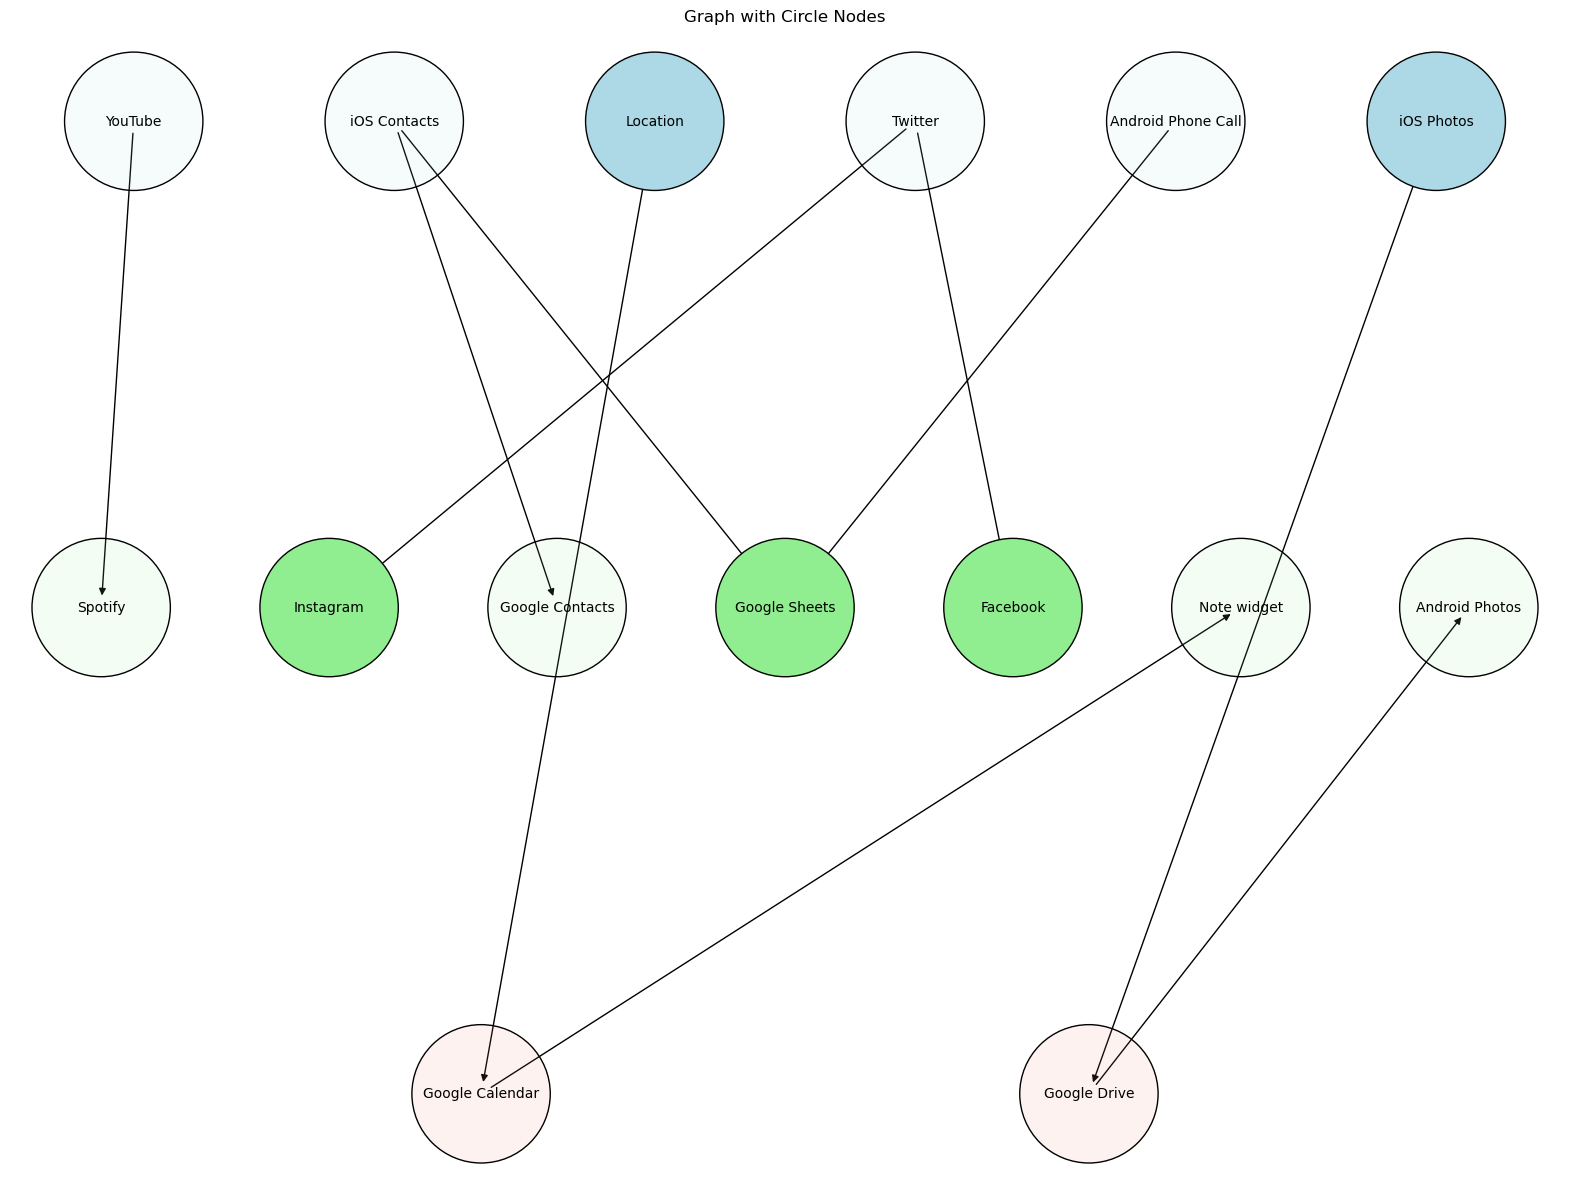

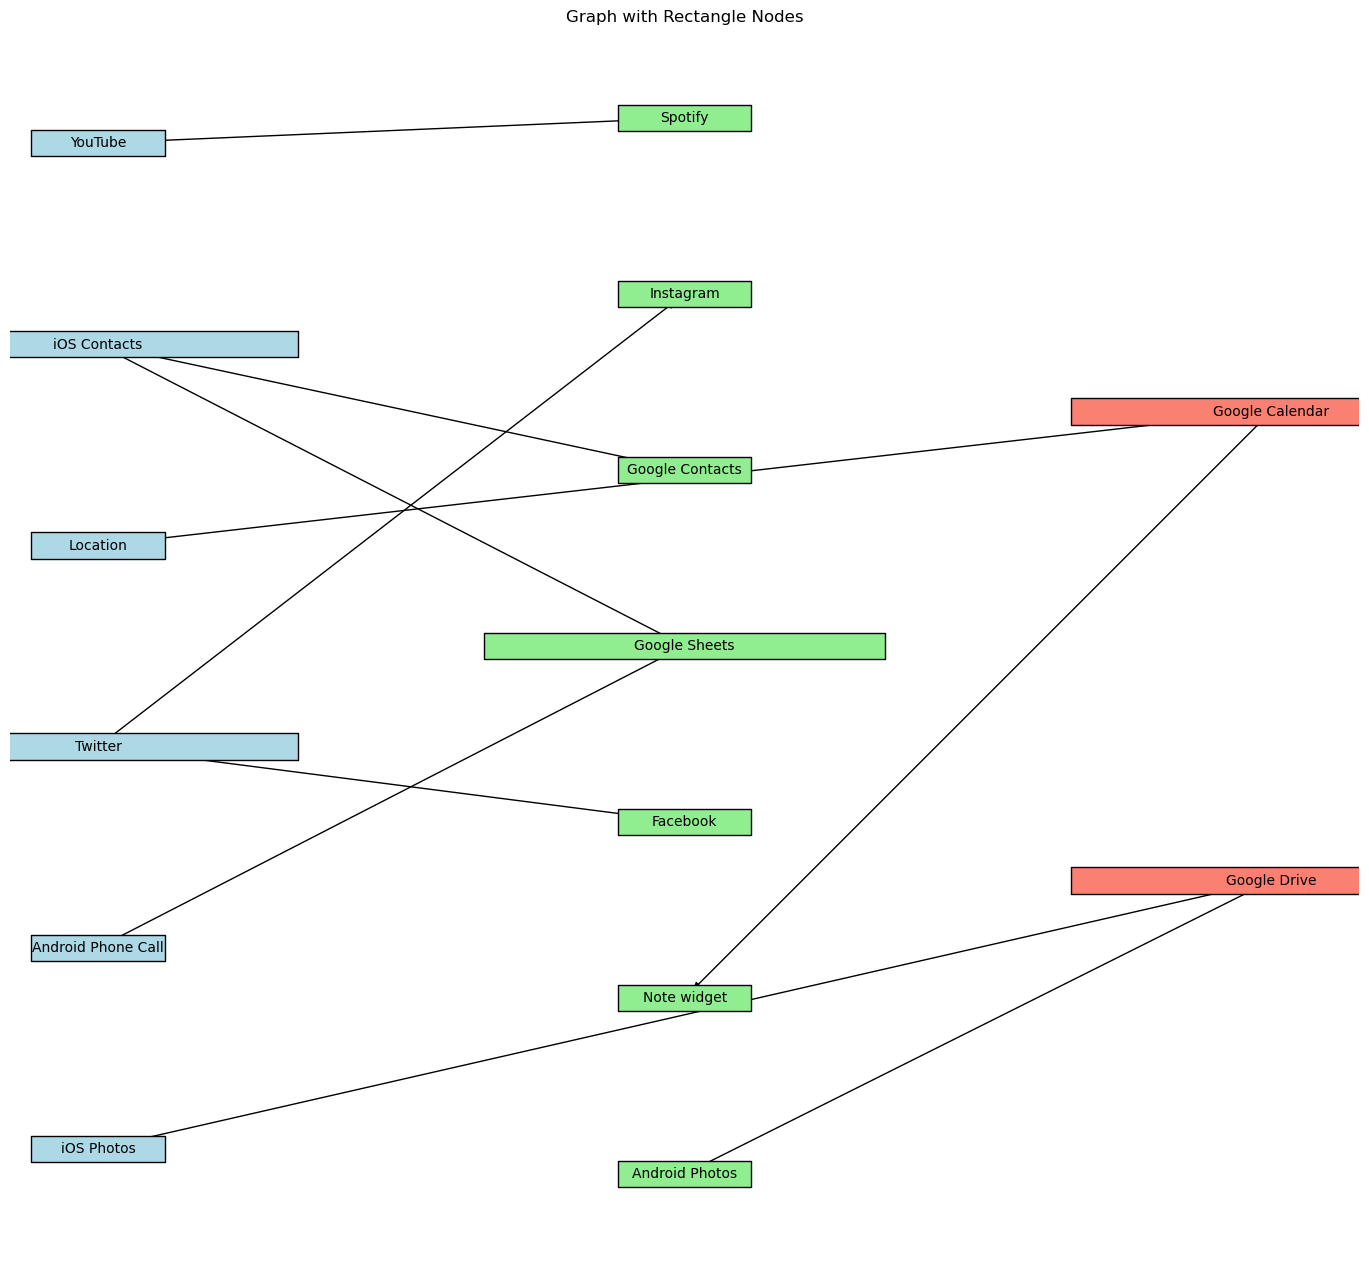

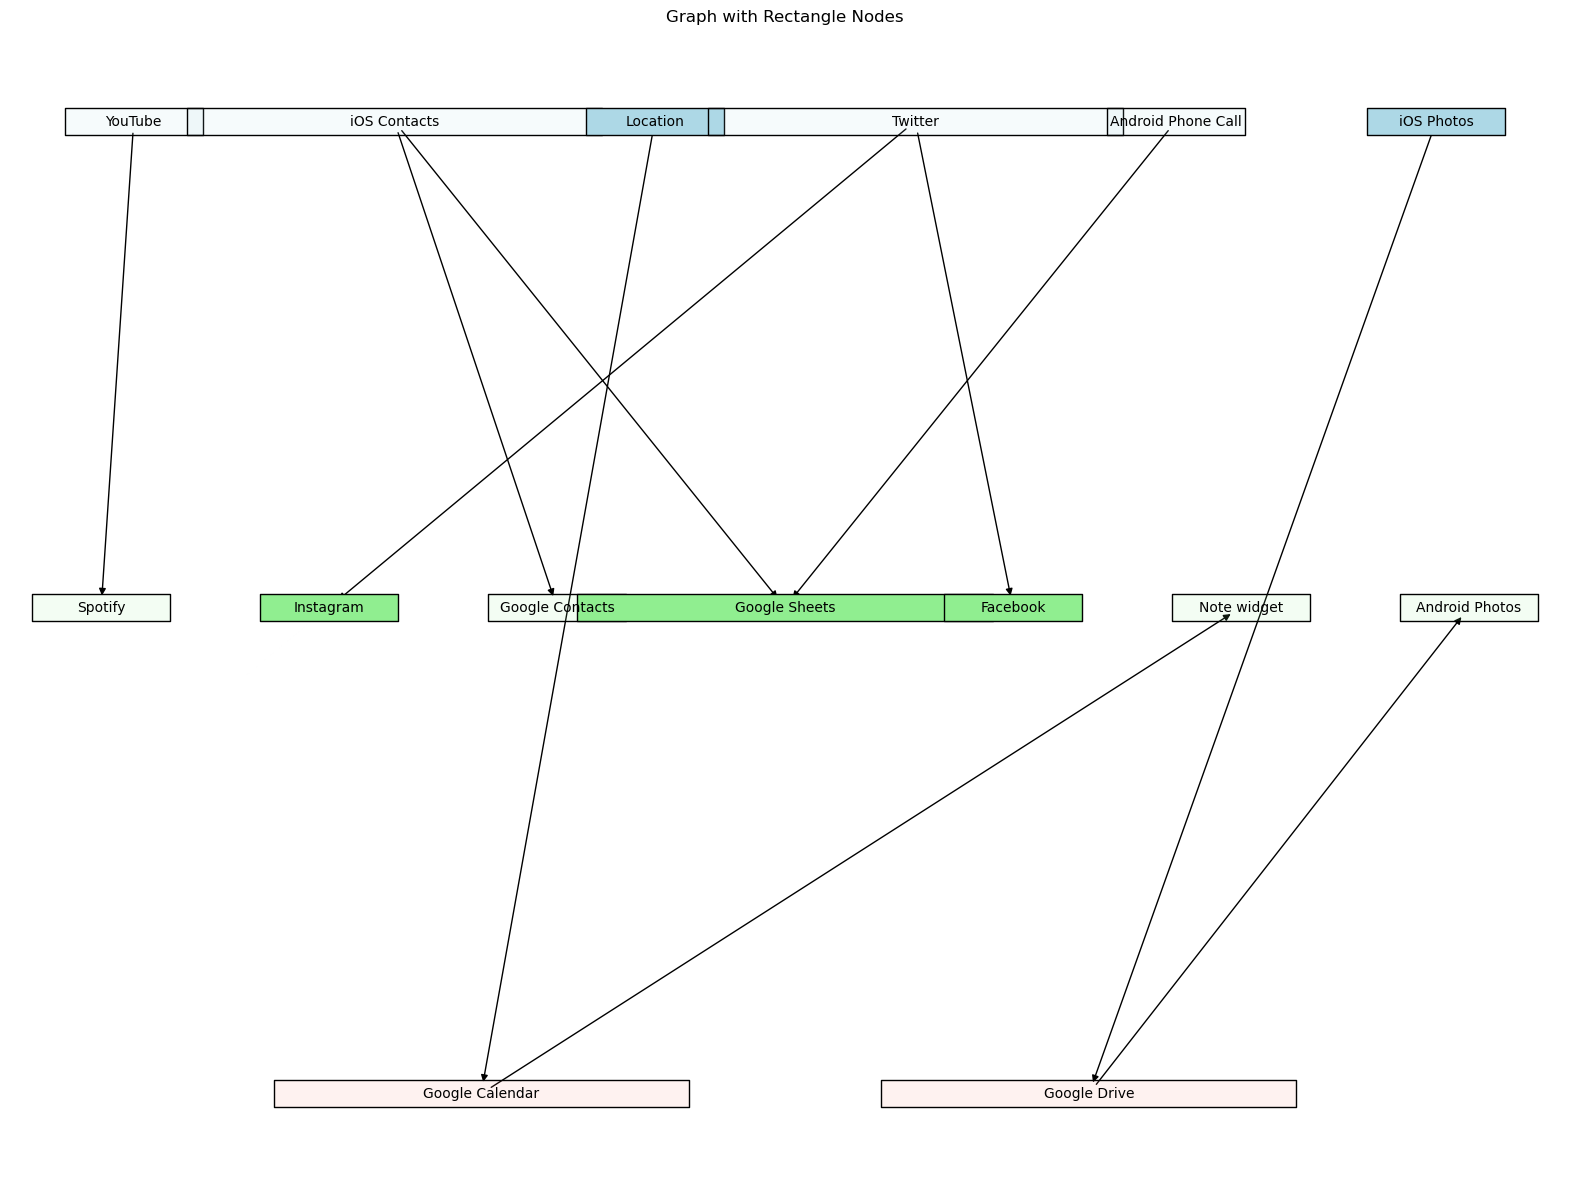

In [6]:
G, pos = draw_graph_with_rect_nodes_flexible(G, pos='orizontal', scale_nodes=False, scale_by='degree', alpha_mode='degree', figsize=(20, 16), label_offset=0.0, node_shape='circle')
G, pos = draw_graph_with_rect_nodes_flexible(G, pos='vertical', scale_nodes=True, scale_by='degree', alpha_mode='fixed', figsize=(20, 16), label_offset=0.0, node_shape='rectangle')
G, pos = draw_graph_with_rect_nodes_flexible(G, pos='orizontal', scale_nodes=True, scale_by='degree', alpha_mode='degree', figsize=(20, 16), label_offset=0.0, node_shape='rectangle')


## APP

In [7]:
edge_trace, annotations = create_edges_and_annotations(G, pos)
node_trace = create_node_trace(G, pos)
node_images = create_node_images(G, pos, NODE_IMAGE_MAP)
app = Dash(__name__)
app.layout = create_dash_layout(edge_trace, node_trace, annotations, node_images)

In [9]:
@app.callback(
    Output('node-info', 'children'),
    Input('network-graph', 'clickData')
)
def callback(clickData):
    return display_node_info(G, clickData, graph_info)

if __name__ == '__main__':
    app.run(debug=True)